# ELMo-LSA-SVM Model
- Uses GPU if available
- Creates pickle files for the ELMo embeddings under "/embeddings/ELMo/"

---

**TODO**
- LSA Step
- SVM Step
- Metrics

In [27]:
## turn off warnings for cleaner execution
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## IMPORTS
# GLOVE Embeddings
import spacy

# ELMo
import tensorflow as tf
import tensorflow_hub as hub
import pickle
import time
import os
from sklearn.model_selection import train_test_split

# SVM
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
import scipy.stats as stats
from sklearn.model_selection import ParameterGrid

# Preprocessing
import csv
import chardet
import numpy as np
import re
import pandas as pd
import demoji
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# metrics
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, balanced_accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /home/cream/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# check if gpu is being used
num_gpu = len(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", num_gpu)

print("Using GPU" if num_gpu > 0 else "Not Using GPU")

Num GPUs Available:  1
Using GPU


In [3]:
# Load the dataset / read csv
# MAKE SURE CSV IS IN UTF-8 (if tweets have emojis)

## Testing if csv can open (Use for troubleshooting)
# with open('Eng_Tweets.csv') as csv_file:
#   csvFile = csv.reader(csv_file, delimiter=',')
#   for row in csv_file:
#     print(row)

pd.set_option('display.max_colwidth', None)
csv_path = 'Eng_Tweets.csv'

df = pd.read_csv(csv_path)
print("total rows: " + str(len(df)))
df.head() ## head won't show emojis unless using print function

total rows: 2335


,Username,Tweet,Date posted,Label
0,@fudaishii,i'm genuinely going to attempt tonight i can't do this anymore i can't handle all this stress i wish i was never born bro,9/11/24,1.0
1,@yourdystiny,"Becoming less reactive is a huge part of growth & decreasing stress. If you let everything get you worked up, you’ll damage your mind, body & spirit.",9/8/24,0.0
2,@ocenhxu,me ??? tired ??? stressed ??? exhausted ??? i wanna cry ??? yes.,9/8/24,1.0
3,@ifeelgoodto,"skipping meals, irregular sleeping habits, overthinking, stress, tired and drained. that's me, that's my everyday life",9/10/24,0.0
4,@ysuckme,"you deserve to be happy. not confused, not hurt, not stressed, just happy.",9/8/24,0.0


## Preprocessing
- Remove mentions (@)
- Remove hashtags (#)
- Remove URLs
- Replace emojis with textual description (Using demoji)
- Remove stop words

In [4]:
### PREPROCESSING STEPS
def clean_text(text):
  # Remove mentions
  text = re.sub(r'@[A-Za-z0-9_]+', '', text)
  # Remove hashtags
  text = re.sub(r'#\w+', '', text)
  # Remove URLs
  text = re.sub(r'http\S+|www\S+|https\S+', '', text)
  # Replace emoji with textual descriptions
  text = demoji.replace_with_desc(text)
  text = re.sub(r'(:[a-zA-Z\s]+:)', r' \1 ', text) # Add spaces around the shortcode
  text = re.sub(r'(:[a-zA-Z\s]+:)', lambda match: match.group(0).replace(' ', '_'), text)
  text = text.strip()
  return text

stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
  words = text.split()
  filtered_words = [word for word in words if word.lower() not in stop_words]
  return ' '.join(filtered_words)

df = df.dropna() # Get rid of NaN rows
df['Tweet'] = df['Tweet'].apply(clean_text)
df['Tweet'] = df['Tweet'].apply(remove_stopwords)

In [5]:
# df.head()

In [6]:
# print(df.loc[24])

## GloVe Embeddings
- Make sure to run "python -m spacy download en_core_web_md"
- GloVe embeddings are then averaged and standardized
- Train-Test-Validation split = 70% - 20% - 10%
- Uses undersampling to balance the training set

In [7]:
nlp = spacy.load("en_core_web_md", disable=["tagger", "parser", "ner"]) # disable non word-embedding parts of spacy

# Create an empty list to store the embeddings
embeddings = []

# Iterate through the DataFrame
for index, row in df.iterrows():
    tweet = row['Tweet']
    doc = nlp(tweet)

    # Get the embeddings for each token and store them
    tweet_embeddings = [token.vector for token in doc]
    embeddings.append(tweet_embeddings)

# Add the embeddings to the DataFrame as a new column
df['embeddings'] = embeddings

/home/cream/project/tf-gpu/tf-gpu/lib/python3.12/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [8]:
# Function to average embeddings for a tweet
def average_embeddings(embeddings_list):
    if embeddings_list:
        return np.mean(embeddings_list, axis=0)
    else:
        return np.zeros(300)  # 300 = embedding dimension

In [9]:
# Function to split the dataset into train, validation, and test
def split_data(df, train_size=0.7, val_size=0.1, test_size=0.2):
    # 70% into training 30% into validation + testing 
    train_df, temp_df = train_test_split(df, train_size=train_size, random_state=42)
    
    # 30% splits 10% into validation and 20% into testing
    val_df, test_df = train_test_split(temp_df, train_size=val_size / (val_size + test_size), random_state=42)
    
    return train_df, val_df, test_df

In [10]:
# Average the sentence embedding into a single entry
df['avg_embedding'] = df['embeddings'].apply(average_embeddings)

# Split the dataset
train_df, val_df, test_df = split_data(df)

In [11]:
# print(f"Train set shape: {X_train.shape}")
# print(f"Validation set shape: {X_val.shape}")
# print(f"Test set shape: {X_test.shape}")

## Run ELMo in batches
- Splits data into train-test-validate (70%-20%-10%)
- Uses the default ELMo model
- Max Sequence Length for embedding padding
- Done in batches to avoid computational overload

In [12]:
# Batch processing elmo with padding
def process_in_batches(df, batch_size=50, max_seq_length=280, pickle_dir="embeddings/ELMo/"):
    num_rows = len(df)
    
    # Ensure the directory exists for saving pickled files
    os.makedirs(pickle_dir, exist_ok=True)
    
    # Iterate over the dataframe in chunks of batch_size
    for start_idx in range(0, num_rows, batch_size):
        end_idx = min(start_idx + batch_size, num_rows)
        batch = df["Tweet"].iloc[start_idx:end_idx]

        # Measure time for each batch
        start = time.time()
        embeddings_tensor = elmo(tf.constant(batch))["elmo"]
        end = time.time()
        
        length = end - start
        print(f"Processed rows {start_idx} to {end_idx - 1}")
        print("Time Taken for batch: ", length, "seconds")
        print("Embedding Shape for batch: ", embeddings_tensor.shape, "\n")
        
        # Pad all sequences in the batch to the fixed max length
        padded_batch_embeddings = []
        for i in range(embeddings_tensor.shape[0]):
            seq_length = embeddings_tensor[i].shape[0]
            padding_needed = max_seq_length - seq_length
            # Pad the sequence with zeros (pad to match the max length)
            padded_seq = tf.pad(embeddings_tensor[i], [[0, padding_needed], [0, 0]], mode='CONSTANT')
            padded_batch_embeddings.append(padded_seq)
        
        # Stack the padded embeddings into a tensor
        padded_batch_embeddings = tf.stack(padded_batch_embeddings)

        # Save the embeddings for this batch to a pickle file
        pickle_file = os.path.join(pickle_dir, f"batch_{start_idx}_embeddings.pkl")
        with open(pickle_file, 'wb') as f:
            pickle.dump(padded_batch_embeddings.numpy(), f)
        
        print(f"Saved embeddings for batch {start_idx} to {pickle_file}")

In [13]:
# Load ELMo default model
print("Downloading elmo model at: \"https://tfhub.dev/google/elmo/2\"")
elmo = hub.load("https://tfhub.dev/google/elmo/2").signatures["default"]
print("Loaded elmo model")

# Sequence length for padding (should be >= max tweet length in dataset)
MAX_SEQ_LEN = 280

# Assuming 'df' is the dataframe with your dataset and the column containing text is "Tweet"
train_df, val_df, test_df = split_data(df, train_size=0.7, val_size=0.1, test_size=0.2)

# Process the train, validation, and test data
print("Processing train dataset...")
start_total = time.time()
process_in_batches(train_df, batch_size=50, max_seq_length=MAX_SEQ_LEN, pickle_dir="embeddings/ELMo/train/")
end_total = time.time()
print(f"Total Time for Training Set: {end_total - start_total} seconds")

print("Processing validation dataset...")
start_total = time.time()
process_in_batches(val_df, batch_size=50, max_seq_length=MAX_SEQ_LEN, pickle_dir="embeddings/ELMo/val/")
end_total = time.time()
print(f"Total Time for Validation Set: {end_total - start_total} seconds")

print("Processing test dataset...")
start_total = time.time()
process_in_batches(test_df, batch_size=50, max_seq_length=MAX_SEQ_LEN, pickle_dir="embeddings/ELMo/test/")
end_total = time.time()
print(f"Total Time for Test Set: {end_total - start_total} seconds")

total_time = end_total - start_total
print("Generated Embeddings for entire dataset")
print("Total Time Taken: ", total_time, "seconds")

I0000 00:00:1732599145.708300    2631 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Loaded elmo model
Processing train dataset...


I0000 00:00:1732599148.278639    2709 cuda_dnn.cc:529] Loaded cuDNN version 90300


Processed rows 0 to 49
Time Taken for batch:  4.766628265380859 seconds
Embedding Shape for batch:  (50, 51, 1024) 

Saved embeddings for batch 0 to embeddings/ELMo/train/batch_0_embeddings.pkl
Processed rows 50 to 99
Time Taken for batch:  0.9608778953552246 seconds
Embedding Shape for batch:  (50, 33, 1024) 

Saved embeddings for batch 50 to embeddings/ELMo/train/batch_50_embeddings.pkl
Processed rows 100 to 149
Time Taken for batch:  2.8301656246185303 seconds
Embedding Shape for batch:  (50, 108, 1024) 

Saved embeddings for batch 100 to embeddings/ELMo/train/batch_100_embeddings.pkl
Processed rows 150 to 199
Time Taken for batch:  0.34576916694641113 seconds
Embedding Shape for batch:  (50, 33, 1024) 

Saved embeddings for batch 150 to embeddings/ELMo/train/batch_150_embeddings.pkl
Processed rows 200 to 249
Time Taken for batch:  1.6368663311004639 seconds
Embedding Shape for batch:  (50, 55, 1024) 

Saved embeddings for batch 200 to embeddings/ELMo/train/batch_200_embeddings.pkl


## Combining GloVe and ELMo Embeddings
- Load ELMo Embeddings
- Combine it with the GloVe Embeddings via vstack, average pooling, or Principal Component Analysis
- Feed this combined embedding into the SVM

In [14]:
import pickle
import numpy as np

# def load_elmo_embeddings(pickle_dir, num_batches):
def load_elmo_embeddings(pickle_dir, batch_start=0, batch_step=50, max_batches=None):
    # elmo_embeddings = []
    # for batch_idx in range(num_batches):
    #     pickle_file = f"{pickle_dir}/batch_{batch_idx}_embeddings.pkl"
    #     with open(pickle_file, 'rb') as f:
    #         batch_embeddings = pickle.load(f)  # Shape: (batch_size, max_seq_length, embedding_dim)
    #         # Average across the sequence length to get a fixed-size embedding
    #         batch_avg_embeddings = np.mean(batch_embeddings, axis=1)  # Shape: (batch_size, embedding_dim)
    #         elmo_embeddings.extend(batch_avg_embeddings)
    # return np.array(elmo_embeddings)


    """
    Load ELMo embeddings from pickle files with custom naming convention.
    
    Args:
        pickle_dir (str): Directory where the pickle files are stored.
        batch_start (int): Starting index for the batches (default: 0).
        batch_step (int): Increment step for batch indices in file names (default: 50).
        max_batches (int): Maximum number of batches to load (default: None, load all).
    
    Returns:
        np.ndarray: Averaged ELMo embeddings for all batches combined.
    """
    elmo_embeddings = []
    batch_index = batch_start
    batch_count = 0
    
    while True:
        pickle_file = f"{pickle_dir}/batch_{batch_index}_embeddings.pkl"
        
        try:
            # Open the pickle file
            with open(pickle_file, 'rb') as f:
                batch_embeddings = pickle.load(f)  # Shape: (batch_size, max_seq_length, embedding_dim)
                # Average across the sequence length to get a fixed-size embedding
                batch_avg_embeddings = np.mean(batch_embeddings, axis=1)  # Shape: (batch_size, embedding_dim)
                elmo_embeddings.extend(batch_avg_embeddings)
        except FileNotFoundError:
            print(f"File not found: {pickle_file}. Stopping batch loading.")
            break
        
        # Update batch index
        batch_index += batch_step
        batch_count += 1
        
        # Stop if the maximum number of batches is reached
        if max_batches is not None and batch_count >= max_batches:
            break
    
    return np.array(elmo_embeddings)

# Load ELMo embeddings for train, validation, and test sets
# train_elmo_embeddings = load_elmo_embeddings("embeddings/ELMo/train", num_batches=len(train_df) // 50)
# val_elmo_embeddings = load_elmo_embeddings("embeddings/ELMo/val", num_batches=len(val_df) // 50)
# test_elmo_embeddings = load_elmo_embeddings("embeddings/ELMo/test", num_batches=len(test_df) // 50)

# Load ELMo embeddings for training data
train_elmo_embeddings = load_elmo_embeddings(
    pickle_dir="embeddings/ELMo/train",
    batch_start=0,    # Start from batch_0_embeddings.pkl
    batch_step=50,    # Increment by 50 for subsequent batches
    max_batches=None  # Load all available batches
)

# Load ELMo embeddings for validation data
val_elmo_embeddings = load_elmo_embeddings(
    pickle_dir="embeddings/ELMo/val",
    batch_start=0,    # Start from batch_0_embeddings.pkl
    batch_step=50     # Increment by 50 for subsequent batches
)

# Load ELMo embeddings for test data
test_elmo_embeddings = load_elmo_embeddings(
    pickle_dir="embeddings/ELMo/test",
    batch_start=0,    # Start from batch_0_embeddings.pkl
    batch_step=50     # Increment by 50 for subsequent batches
)


# Ensure the embeddings align with DataFrame rows
assert len(train_elmo_embeddings) == len(train_df)
assert len(val_elmo_embeddings) == len(val_df)
assert len(test_elmo_embeddings) == len(test_df)

File not found: embeddings/ELMo/train/batch_1650_embeddings.pkl. Stopping batch loading.
File not found: embeddings/ELMo/val/batch_250_embeddings.pkl. Stopping batch loading.
File not found: embeddings/ELMo/test/batch_500_embeddings.pkl. Stopping batch loading.


In [15]:
# X_train = np.array(train_df['avg_embedding'].to_list())
y_train = train_df['Label']
# X_val = np.array(val_df['avg_embedding'].to_list())
y_val = val_df['Label']
# X_test = np.array(test_df['avg_embedding'].to_list())
y_test = test_df['Label']

# Concatenate SpaCy and ELMo embeddings
X_train = np.hstack((np.array(train_df['avg_embedding'].to_list()), train_elmo_embeddings))
X_val = np.hstack((np.array(val_df['avg_embedding'].to_list()), val_elmo_embeddings))
X_test = np.hstack((np.array(test_df['avg_embedding'].to_list()), test_elmo_embeddings))

# # Undersample the training set to balance the classes using RandomUnderSampler
# undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
# X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Optionally, check the class distribution after undersampling
print(f"Class distribution after undersampling:\n{pd.Series(y_train_resampled).value_counts()}")

Class distribution after undersampling:
Label
0.0    1279
1.0    1279
Name: count, dtype: int64


In [16]:
print(f"Train set shape: {X_train_resampled.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Train set shape: (2558, 1324)
Validation set shape: (233, 1324)
Test set shape: (467, 1324)


## SVM (Support Vector Machine)

In [17]:
model = SVC(probability=True, kernel='linear', random_state=42)
model.fit(X_train_resampled, y_train_resampled)

SVC(kernel='linear', probability=True, random_state=42)

In [18]:
# Train the model using SVC
# model = SVC(probability=True)
# model.fit(X_train_final, y_train_resampled)

In [19]:
# # Define the parameter grid to search
# param_grid = {
#     'C': [0.1, 1, 10, 100],  # Regularization parameter
#     'kernel': ['linear', 'rbf', 'poly'],  # Type of kernel
#     'gamma': ['scale', 'auto', 0.1, 1],  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
#     'class_weight': [None, 'balanced'],  # Class weight for handling imbalanced datasets
# }

# # Define a function to modify the parameter grid for 'degree'
# def filter_degree(param_grid):
#     # Generate all combinations of the parameter grid
#     grid = list(ParameterGrid(param_grid))

#     # Filter out invalid combinations where 'degree' is used without 'poly' kernel
#     valid_grid = []
#     for params in grid:
#         if params['kernel'] == 'poly' and 'degree' not in params:
#             # Ensure degree is included when using 'poly' kernel
#             params['degree'] = [3]  # Default value for degree (as a list)
#         elif params['kernel'] != 'poly' and 'degree' in params:
#             # Remove degree for non-'poly' kernels
#             del params['degree']
        
#         # Ensure all parameters are in list format
#         for key in params:
#             if not isinstance(params[key], list):
#                 params[key] = [params[key]]

#         valid_grid.append(params)
    
#     return valid_grid

# # Filtered parameter grid based on the kernel
# filtered_param_grid = filter_degree(param_grid)

# # Initialize the SVC model
# svc = SVC(probability=True)

# # Set up the GridSearchCV with cross-validation (5-fold cross-validation in this example)
# grid_search = GridSearchCV(
#     estimator=svc, 
#     param_grid=filtered_param_grid, 
#     cv=5, 
#     n_jobs=-1, 
#     verbose=3, 
#     scoring='accuracy'
# )

# # Fit the grid search to the training data
# # grid_search.fit(X_train_final, y_train_resampled)
# grid_search.fit(X_train, y_train) # not final because that is an LSA-exclusive process

# # Get the best parameters and best score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# # Print the best results
# print(f"Best parameters found: {best_params}")
# print(f"Best cross-validation accuracy: {best_score}")

In [20]:
# Linear SVM
# Modify param_grid for linear kernel
# param_grid_linear = {
#     'C': [1, 10],
#     'kernel': ['linear'],  # Only linear kernel
#     'class_weight': [None, 'balanced'],  # Class weight
# }

# # Initialize the SVC model
# svc = SVC(probability=True)

# # Define the GridSearchCV object with StratifiedKFold
# grid_search_linear = GridSearchCV(
#     estimator=svc,
#     param_grid=param_grid_linear,
#     cv=stratified_kfold,
#     n_jobs=-1,
#     verbose=3,
#     scoring='accuracy'
# )

# # Fit the grid search to the training data
# with parallel_backend('multiprocessing'):
#     grid_search_linear.fit(X_train_final, y_train_resampled)

# # Get the best parameters and best score for linear kernel
# best_params_linear = grid_search_linear.best_params_
# best_score_linear = grid_search_linear.best_score_

# # Print the results for linear kernel
# print(f"Best parameters for linear kernel: {best_params_linear}")
# print(f"Best cross-validation Accuracy for linear kernel: {best_score_linear:.4f}")


# # RBF

# # Modify param_grid for rbf kernel
# param_grid_rbf = {
#     'C': [0.1, 1, 10, 100],
#     'kernel': ['rbf'],  # Only rbf kernel
#     'gamma': ['scale', 'auto', 0.1, 1],  # Gamma values for RBF
#     'class_weight': [None, 'balanced'],  # Class weight
# }

# # Define the GridSearchCV object for rbf kernel
# grid_search_rbf = GridSearchCV(
#     estimator=svc,
#     param_grid=param_grid_rbf,
#     cv=stratified_kfold,
#     n_jobs=-1,
#     verbose=3,
#     scoring='accuracy'
# )

# # Fit the grid search to the training data
# with parallel_backend('multiprocessing'):
#     grid_search_rbf.fit(X_train_final, y_train_resampled)

# # Get the best parameters and best score for rbf kernel
# best_params_rbf = grid_search_rbf.best_params_
# best_score_rbf = grid_search_rbf.best_score_

# # Print the results for rbf kernel
# print(f"Best parameters for rbf kernel: {best_params_rbf}")
# print(f"Best cross-validation Accuracy for rbf kernel: {best_score_rbf:.4f}")


# # Poly

# # Modify param_grid for poly kernel
# param_grid_poly = {
#     'C': [0.1, 1, 10, 100],
#     'kernel': ['poly'],  # Only poly kernel
#     'gamma': ['scale', 'auto', 0.1, 1],  # Gamma values for poly
#     'degree': [3],  # Degree of the polynomial kernel (default is 3)
#     'class_weight': [None, 'balanced'],  # Class weight
# }

# # Define the GridSearchCV object for poly kernel
# grid_search_poly = GridSearchCV(
#     estimator=svc,
#     param_grid=param_grid_poly,
#     cv=stratified_kfold,
#     n_jobs=-1,
#     verbose=3,
#     scoring='accuracy'
# )

# # Fit the grid search to the training data
# with parallel_backend('multiprocessing'):
#     grid_search_poly.fit(X_train_final, y_train_resampled)

# # Get the best parameters and best score for poly kernel
# best_params_poly = grid_search_poly.best_params_
# best_score_poly = grid_search_poly.best_score_

# # Print the results for poly kernel
# print(f"Best parameters for poly kernel: {best_params_poly}")
# print(f"Best cross-validation Accuracy for poly kernel: {best_score_poly:.4f}")

In [21]:
# Using the best parameters from grid search or random search
# best_model = grid_search.best_estimator_  # or 
# best_model = random_search.best_estimator_

# Final evaluation on the test set
# y_pred_test = best_model.predict(X_test)
# accuracy_test = accuracy_score(y_test, y_pred_test)
# print(f"Test Accuracy: {accuracy_test}")

Validation Accuracy: 0.7253218884120172
Validation Precision: 0.43902439024390244
Validation Recall: 0.6666666666666666
Validation F1 Score: 0.5294117647058824
Validation Balanced Accuracy: 0.7048417132216015
Validation Confusion Matrix: 
[[133  46]
 [ 18  36]]
Test Accuracy: 0.8201284796573876
Test Precision: 0.5161290322580645
Test Recall: 0.7272727272727273
Test F1 Score: 0.6037735849056604
Test Balanced Accuracy: 0.7844806908131446
Test Confusion Matrix: 
[[319  60]
 [ 24  64]]
Test ROC AUC: 0.8645958263372511


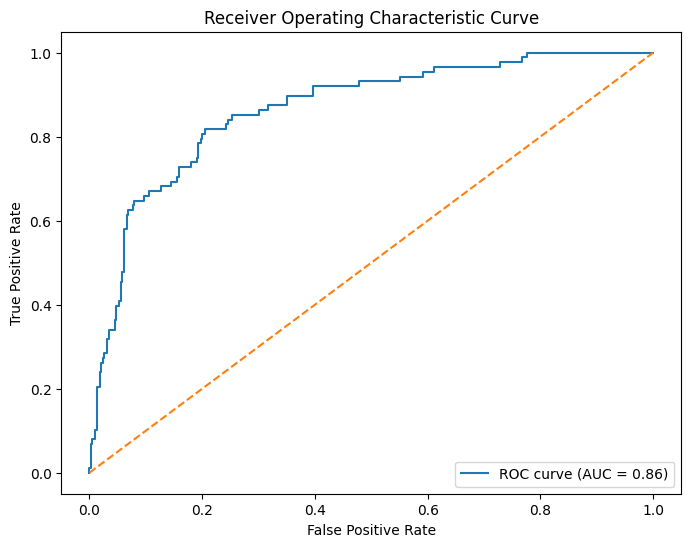

In [22]:
# Evaluation on validation set
# y_pred_val = best_model.predict(X_val)
y_pred_val = model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1_val = f1_score(y_val, y_pred_val)
balanced_acc_val = balanced_accuracy_score(y_val, y_pred_val)  # Add balanced accuracy
conf_matrix_val = confusion_matrix(y_val, y_pred_val)

print(f"Validation Accuracy: {accuracy_val}")
print(f"Validation Precision: {precision_val}")
print(f"Validation Recall: {recall_val}")
print(f"Validation F1 Score: {f1_val}")
print(f"Validation Balanced Accuracy: {balanced_acc_val}")  # Print balanced accuracy
print(f"Validation Confusion Matrix: \n{conf_matrix_val}")

# Final evaluation on test set
# y_pred_test = best_model.predict(X_test)
y_pred_test = model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
balanced_acc_test = balanced_accuracy_score(y_test, y_pred_test)  # Add balanced accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

print(f"Test Accuracy: {accuracy_test}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")
print(f"Test F1 Score: {f1_test}")
print(f"Test Balanced Accuracy: {balanced_acc_test}")  # Print balanced accuracy
print(f"Test Confusion Matrix: \n{conf_matrix_test}")

# Compute ROC AUC
# y_prob_test = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
y_prob_test = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
roc_auc = roc_auc_score(y_test, y_prob_test)
print(f"Test ROC AUC: {roc_auc}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()

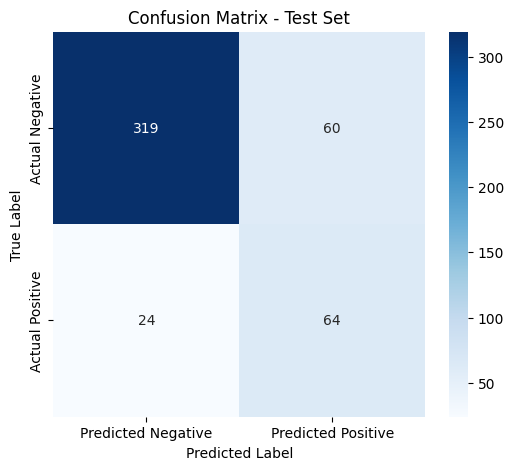

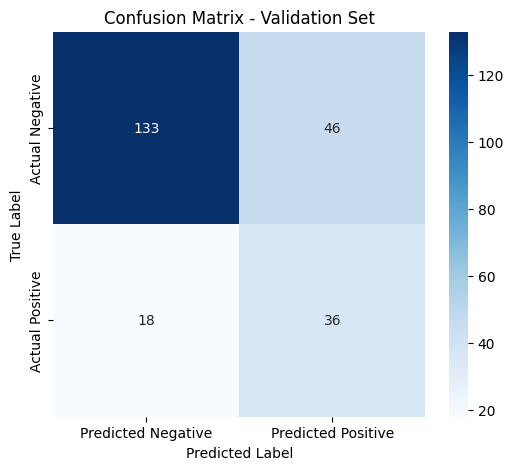

In [23]:
# Plot confusion matrix for test set
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot confusion matrix for validation set
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix - Validation Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [30]:
# Using StratifiedKFold for cross-validation
stratified_cv = StratifiedKFold(n_splits=5)

train_sizes, train_scores, test_scores = learning_curve(
    model, X_train_resampled, y_train_resampled, cv=stratified_cv,  # Use StratifiedKFold
    scoring='accuracy', 
    train_sizes=np.linspace(0.1, 1.0, 10), 
    n_jobs=-1
)

# Calculate the mean and standard deviation of train and test scores
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)

# Print the final scores (for the largest training set size)
print(f"Final Training Score: {train_scores_mean[-1]:.4f}")
print(f"Final Cross-validation Score: {test_scores_mean[-1]:.4f}")

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='green')

# Fill the area between the curve and the axis to represent the standard deviation
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color='green', alpha=0.2)

# Add labels and title
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

KeyboardInterrupt: 